#### Setup - Importing Libraries and Packages

In [1]:
import pathlib
import numpy as np
import pandas as pd
import os, datetime 
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, callbacks, applications, models

#### Data Preparation

In [2]:
file_path = r"C:\Users\HP\Documents\SHRDC\YPAI07_CPU\Hands On\Assesments\Exercise_2_Cracks_CV\Concrete"
data_dir = pathlib.Path(file_path)

SEED = 123
IMG_SIZE = (180, 180)

train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir, shuffle=True, 
                                                            validation_split=0.2, subset="training",
                                                            seed=SEED, image_size = IMG_SIZE , batch_size=32)

Found 40000 files belonging to 2 classes.
Using 32000 files for training.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(data_dir, shuffle=True, 
                                                                 validation_split=0.2, subset="validation",
                                                                 seed=SEED, image_size = IMG_SIZE , batch_size=32)

Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


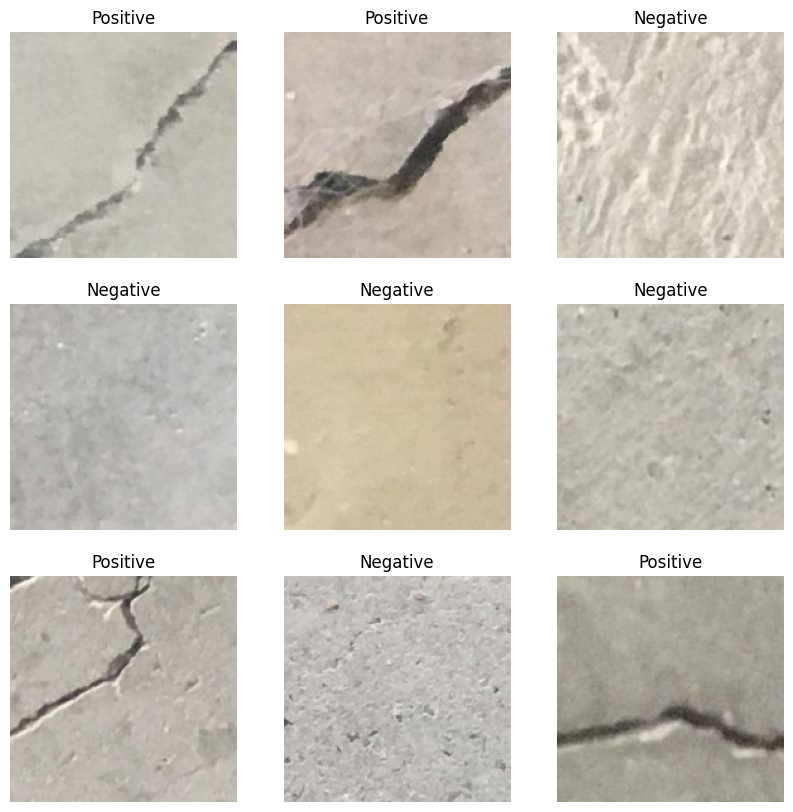

In [4]:
#inspect some data samples
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
#further split the validation dataset into validation-test splits
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches//5)
val_dataset = validation_dataset.skip(val_batches//5)

In [6]:
#convert tensorflow dataset into Prefetch Dataset
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_pf = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset_pf = val_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset_pf = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
#create a sequential model for image augmentation
data_augmentation = tf.keras.Sequential()
data_augmentation.add(tf.keras.layers.RandomFlip())
data_augmentation.add(tf.keras.layers.RandomRotation(0.3))

In [8]:
#data normalization - define a layer for it
preprocess_input = tf.keras.applications.resnet50.preprocess_input

#construct the transfer learning pipeline
#a. load the pretrained model ResNet50 using keras.applications
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(include_top = False, weights = "imagenet", input_shape = IMG_SHAPE)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']      

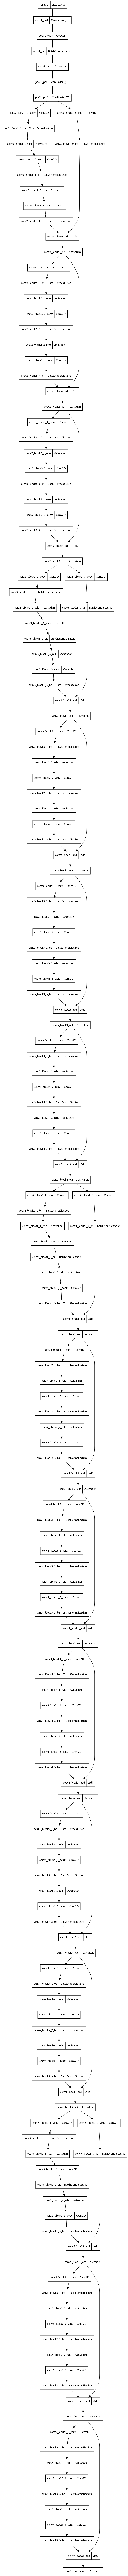

In [9]:
#b. freeze the entire feature extractor
base_model.trainable = False
base_model.summary()
keras.utils.plot_model(base_model) 

In [10]:
#then we add our own classification layer
#c. create global average pooling layer
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()

#d. create the output layer with Dense layer
prediction_layer = tf.keras.layers.Dense(len(class_names), activation="softmax")

In [11]:
#e. build the entire pipeline using functional API

#i. input
inputs = tf.keras.Input(shape=IMG_SHAPE)
#ii. data augmentation
x = data_augmentation(inputs)
#iii. data normalization
x = preprocess_input(x)
#iv. Transfer learning feature extractor
x = base_model(x, training=False)
#v. Classification layers
x = global_avg_layer(x)
outputs = prediction_layer(x)
#vi. Build the model
model = tf.keras.Model(inputs, outputs)
model.summary()
#from the summary we can see that we are only training the dense layer (because we already freeze our FE layer)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

#### Compile and Fit the Model

In [12]:
model.compile(optimizer= "adam", loss = "sparse_categorical_crossentropy", metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, min_delta=0.2)

In [13]:
PATH = os.getcwd()
logpath = os.path.join(PATH, 'Tensorboard_Log', datetime.datetime.now().strftime('%Y%m%d - %H%M%S'))
 
tb = tf.keras.callbacks.TensorBoard(logpath)  #tensorboard to visualize

In [14]:
#evaluate the model before training
before_loss, before_accuracy = model.evaluate(val_dataset_pf)

print("---------------Before Training----------------")
print(f"Loss = {before_loss}")
print(f"Accuracy = {before_accuracy}")

200/200 [==============================] - 942s 5s/step - loss: 0.6429 - accuracy: 0.6319
---------------Before Training----------------
Loss = 0.6428873538970947
Accuracy = 0.6318749785423279


#### Model Training

In [15]:
EPOCH = 20
BATCH_SIZE = 32

history = model.fit(train_dataset_pf, validation_data=val_dataset_pf, epochs = EPOCH, batch_size = BATCH_SIZE, callbacks = [early_stopping, tb])

Epoch 1/20
1000/1000 [==============================] - 5751s 6s/step - loss: 0.0155 - accuracy: 0.9957 - val_loss: 0.0063 - val_accuracy: 0.9986
Epoch 2/20
1000/1000 [==============================] - 5742s 6s/step - loss: 0.0055 - accuracy: 0.9981 - val_loss: 0.0060 - val_accuracy: 0.9986
Epoch 3/20
1000/1000 [==============================] - 5732s 6s/step - loss: 0.0048 - accuracy: 0.9986 - val_loss: 0.0078 - val_accuracy: 0.9984


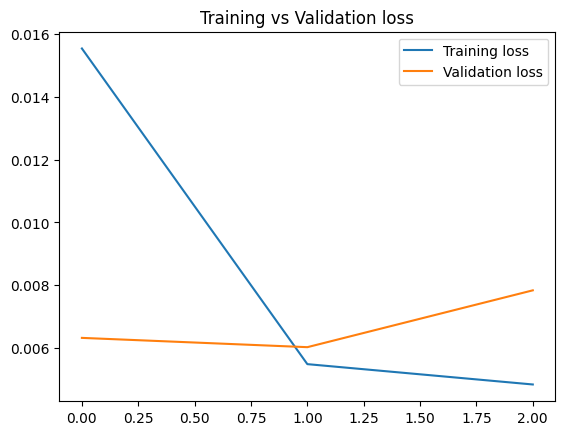

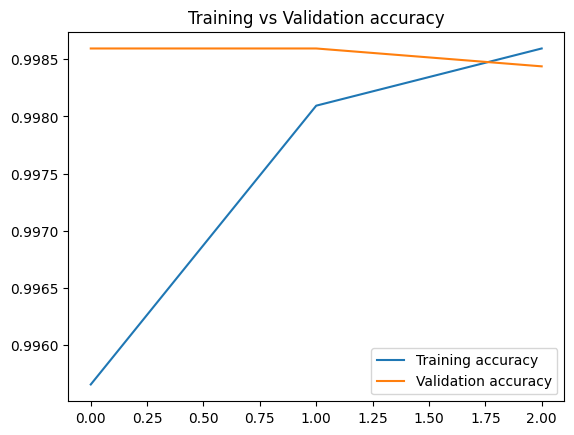

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = history.epoch

plt.plot(epochs, train_loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training vs Validation loss")
plt.legend()
plt.figure()

plt.plot(epochs, train_acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.title("Training vs Validation accuracy")
plt.legend()
plt.figure()

plt.show()

In [17]:
#evaluate model after training
after_loss, after_accuracy = model.evaluate(test_dataset_pf)

print("---------------After Training----------------")
print(f"Loss = {after_loss}")
print(f"Accuracy = {after_accuracy}")

50/50 [==============================] - 232s 5s/step - loss: 0.0058 - accuracy: 0.9987
---------------After Training----------------
Loss = 0.005816249176859856
Accuracy = 0.9987499713897705


#### Model Deployment

In [18]:
#a. retrieve a batch of data from test data and perform prediction
image_batch, label_batch = test_dataset_pf.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

#b. identify the class for the predictions
class_pred = np.argmax(predictions, axis=1)

print(f"Prediction: {class_pred}")
print(f"Labels: {label_batch}")

Prediction: [1 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1]
Labels: [1 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1]


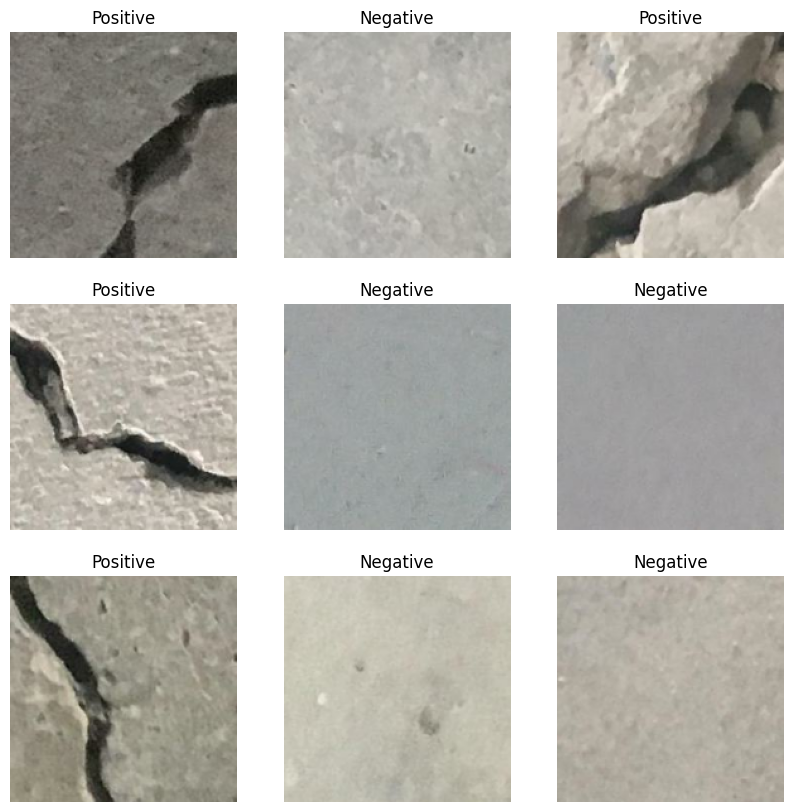

In [19]:
#d. plot the image graph using matplotlib
plt.figure(figsize=(10,10))

for i in range(9):
    axs = plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[class_pred[i]])
    plt.axis("off")

In [20]:
model.save("Cracks_Image_Classification.h5")